# Rescheduling mit Tardiness (Max)
> Planunghorizont Tag 0: 2 Tage <br>
> Rescheduling des Tages 1

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics
import src.models.lp.tardiness_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [2]:
max_time = 60*5 # 5min

In [3]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 2, u_b_mmax= 0.92, shuffle = True)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
465,Job_046,5,M8,52
466,Job_046,6,M7,85
467,Job_046,7,M3,98
468,Job_046,8,M9,22


In [4]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Arrival,Deadline
0,Job_000,0.00,1385.0
1,Job_001,83.09,1871.0
2,Job_002,103.88,2096.0
3,Job_003,145.10,2442.0
4,Job_004,181.06,1559.0
...,...,...,...
42,Job_042,2418.05,4511.0
43,Job_043,2482.56,4271.0
44,Job_044,2596.58,4336.0
45,Job_045,2784.07,4243.0


## I) Complete Scheduling

In [5]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_jssp_max_tardiness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 13000

Solver-Informationen:
  Maximale Tardiness      : 1502.55
  Solver-Status           : Optimal
  Anzahl Variablen        : 11375
  Anzahl Constraints      : 22184

Scheduling-Dauer: 5 Minuten und 1.04 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0.00,1385.0,M0,0.00,29.0,29.00,0.00
1,Job_000,1,0.00,1385.0,M1,29.00,78.0,107.00,0.00
2,Job_000,2,0.00,1385.0,M2,107.00,9.0,116.00,0.00
3,Job_000,3,0.00,1385.0,M3,116.00,36.0,152.00,0.00
4,Job_000,4,0.00,1385.0,M4,152.00,49.0,201.00,0.00
...,...,...,...,...,...,...,...,...,...
465,Job_038,8,2214.72,4511.0,M9,5948.55,22.0,5970.55,1459.55
466,Job_046,7,2879.38,5176.0,M3,5948.55,98.0,6046.55,870.55
467,Job_038,9,2214.72,4511.0,M5,5970.55,43.0,6013.55,1502.55
468,Job_046,8,2879.38,5176.0,M9,6046.55,22.0,6068.55,892.55


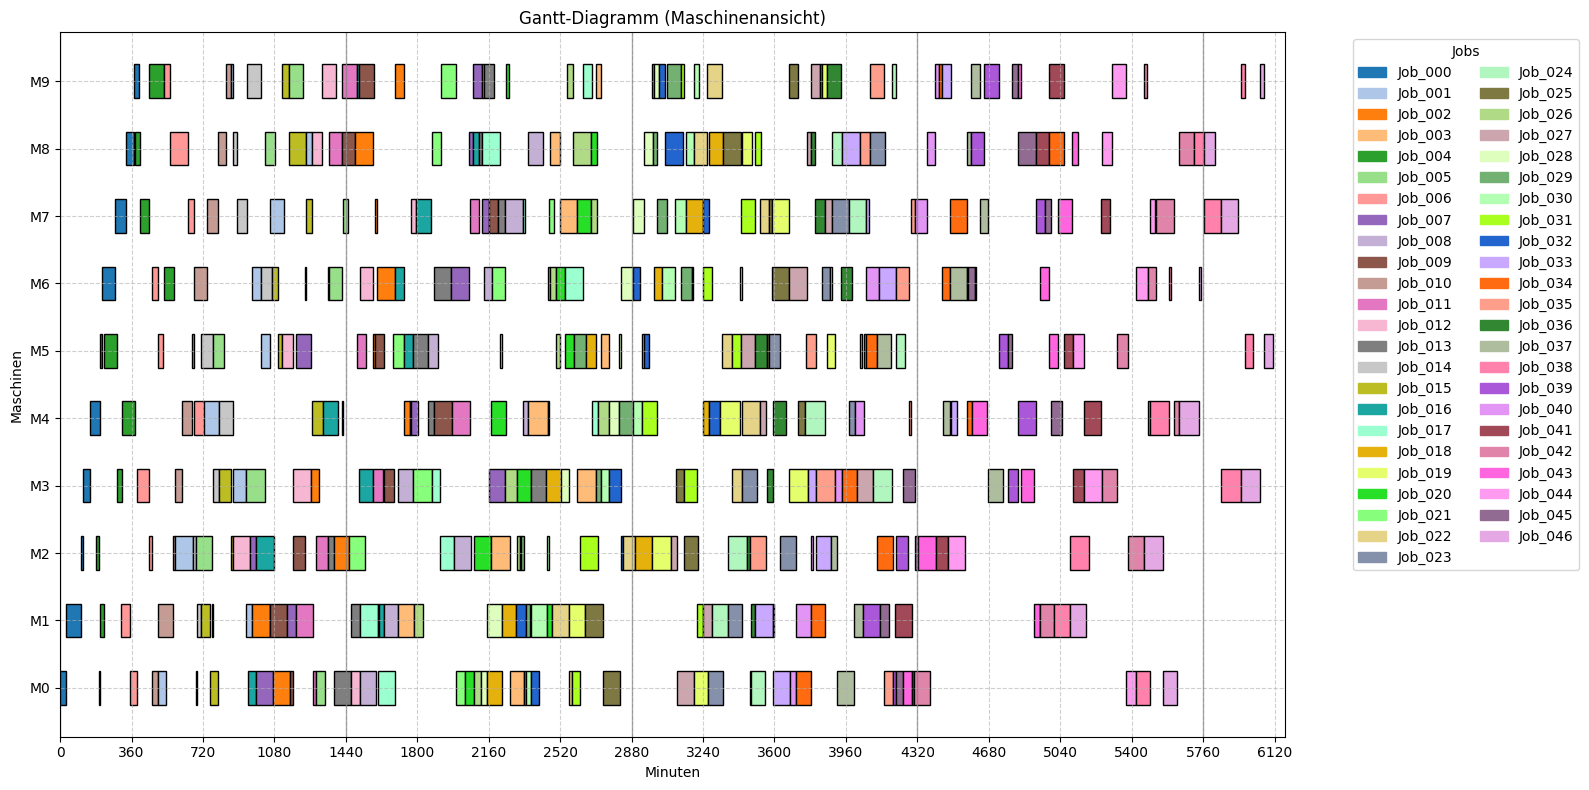

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [6]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [7]:
day_length = 1440

In [8]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [9]:
simulation = ProductionDaySimulation(df_plan, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:47:57] Job_000 finished on M0 (after 47 minutes 57 seconds)
[00:47:57] Job_000 started on M1
[02:09:30] Job_000 finished on M1 (after 81 minutes 34 seconds)
[02:09:30] Job_000 started on M2
[02:21:58] Job_000 finished on M2 (after 12 minutes 28 seconds)
[02:21:58] Job_000 started on M3
[02:53:16] Job_000 finished on M3 (after 31 minutes 18 seconds)
[02:53:16] Job_000 started on M4
[03:01:03] Job_004 started on M2
[03:17:42] Job_004 finished on M2 (after 16 minutes 39 seconds)
[03:17:42] Job_004 started on M0
[03:24:24] Job_004 finished on M0 (after 06 minutes 42 seconds)
[03:24:24] Job_004 started on M1
[03:33:45] Job_000 finished on M4 (after 40 minutes 29 seconds)
[03:33:45] Job_000 started on M5
[03:42:29] Job_004 finished on M1 (after 18 minutes 05 seconds)
[03:44:18] Job_000 finished on M5 (after 10 minutes 33 seconds)
[03:44:18] Job_004 started on M5
[03:44:18] Job_000 started on M6
[04:32:57] Job_000 finished on M6 (after 48 minutes 40 second

In [10]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_011,3,509.07,M6,1349.55,7.0
1,Job_011,4,509.07,M8,1356.55,64.0
2,Job_002,3,103.88,M2,1380.55,74.0
3,Job_011,5,509.07,M9,1420.55,76.0
4,Job_021,0,991.18,M2,1454.55,84.0
...,...,...,...,...,...,...
359,Job_038,8,2214.72,M9,5948.55,22.0
360,Job_046,7,2879.38,M3,5948.55,98.0
361,Job_038,9,2214.72,M5,5970.55,43.0
362,Job_046,8,2879.38,M9,6046.55,22.0


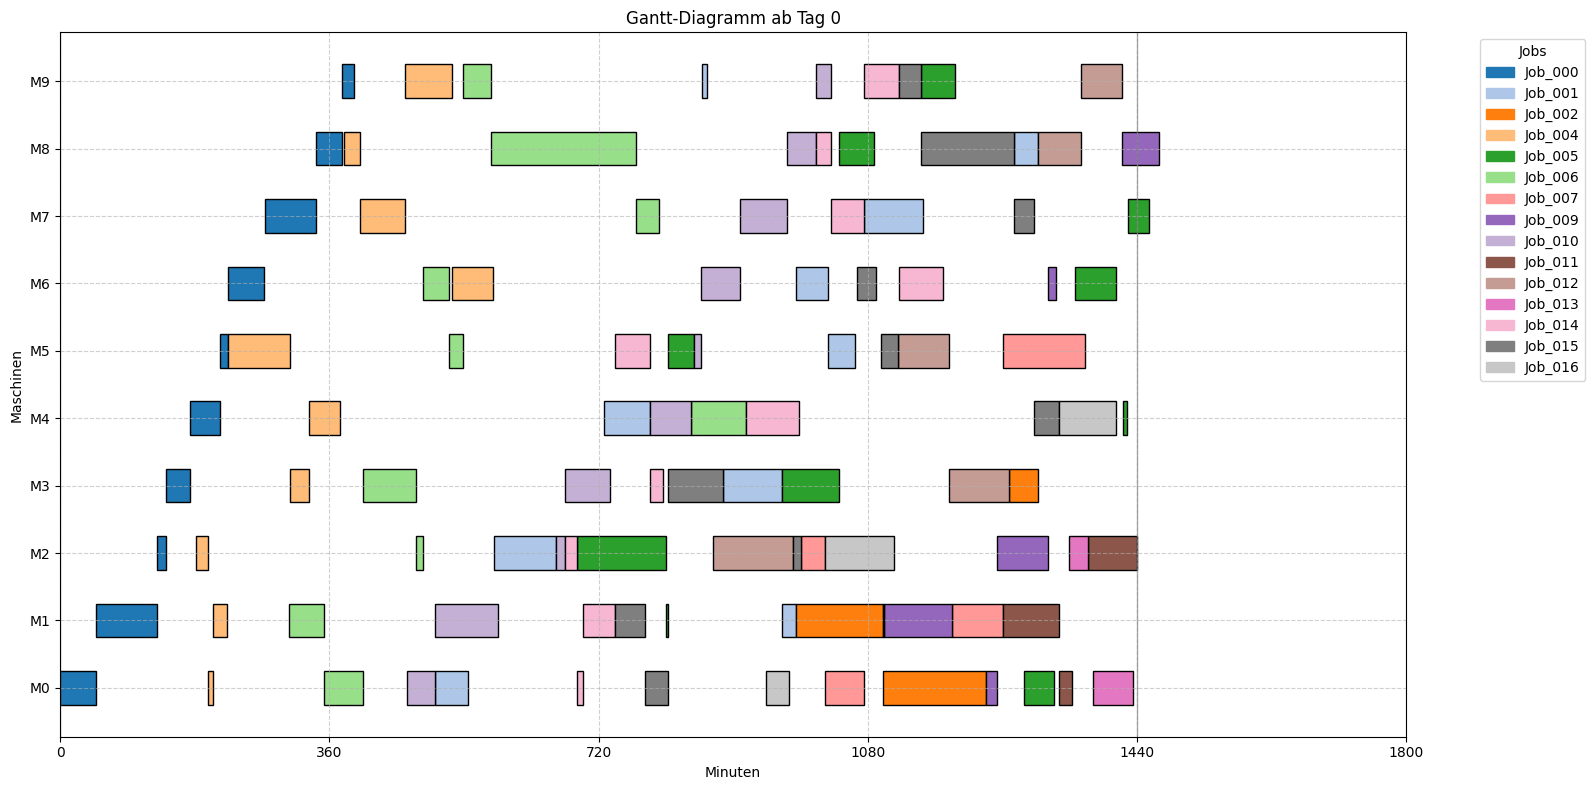

In [11]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [12]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_002,3,103.88,2096.0,M2,1380.55,74.0,1454.55,0.00
1,Job_002,4,103.88,2096.0,M8,1484.55,90.0,1574.55,0.00
2,Job_002,5,103.88,2096.0,M5,1574.55,10.0,1584.55,0.00
3,Job_002,6,103.88,2096.0,M7,1584.55,12.0,1596.55,0.00
4,Job_002,7,103.88,2096.0,M6,1596.55,89.0,1685.55,0.00
...,...,...,...,...,...,...,...,...,...
359,Job_046,5,2879.38,5176.0,M8,5765.55,52.0,5817.55,641.55
360,Job_046,6,2879.38,5176.0,M7,5850.55,85.0,5935.55,759.55
361,Job_046,7,2879.38,5176.0,M3,5948.55,98.0,6046.55,870.55
362,Job_046,8,2879.38,5176.0,M9,6046.55,22.0,6068.55,892.55


In [13]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

NameError: name 'df_times' is not defined

## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [ ]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

In [ ]:
starting_time = time.time()
df_reschedule = solver.solve_jssp_max_tardiness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                                   reschedule_start = 1440,
                                                                   solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

df_reschedule

In [ ]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

### Export

In [ ]:
#df_plan.to_csv(main_file_path.format("0204b_tardiness_max_schedule_og.csv"), index = False)
#df_execution.to_csv(main_file_path.format("0204b_tardiness_max_schedule_simulation.csv"), index = False)
#df_reschedule.to_csv(main_file_path.format("0204b_tardiness_max_schedule_revised.csv"), index = False)

In [ ]:
#df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

#df_schedule_mix = pd.concat([df_execution, df_reschedule], ignore_index=True)
#df_schedule_mix = df_schedule_mix.sort_values(by="Start").reset_index(drop=True)
#df_schedule_mix.to_csv(main_file_path.format("0204b_tardiness_max_schedule_revised_with_sim.csv"), index = False)